Deep Learning lab-03 assignment, Arnav Aditya, Roll no.- 2210110189

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed(42)

Using device: cuda


In [2]:
!nvidia-smi

Fri Sep  5 11:11:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8              3W /   35W |      12MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
class TwoLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation='relu'):
        super(TwoLayerMLP, self).__init__()
        # First layer: W1^T.x + b1
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Second layer: W2^T.x + b2
        self.fc2 = nn.Linear(hidden_size, output_size)

        # Activation function selection
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError("Activation must be 'relu' or 'sigmoid'")

    def forward(self, x):
        # First layer: W1^T.x + b1
        out = self.fc1(x)
        # Activation function
        out = self.activation(out)
        # Second layer: W2^T.x + b2
        out = self.fc2(out)
        return out

In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, problem_type='classification'):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            if problem_type == 'classification':
                loss = criterion(outputs, targets)
            else:  # regression
                loss = criterion(outputs, targets.view(-1, 1))

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average training loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                if problem_type == 'classification':
                    loss = criterion(outputs, targets)
                    _, predicted = torch.max(outputs.data, 1)
                    total += targets.size(0)
                    correct += (predicted == targets).sum().item()
                else:  # regression
                    loss = criterion(outputs, targets.view(-1, 1))

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if problem_type == 'classification':
            val_accuracy = 100 * correct / total
            val_accuracies.append(val_accuracy)
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}, '
                  f'Val Acc: {val_accuracy:.2f}%')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses, val_accuracies

In [5]:
def classification_example():
    print("=== Classification Example ===")

    # Generate moons dataset
    X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.LongTensor(y_train).to(device)
    X_val_t = torch.FloatTensor(X_val).to(device)
    y_val_t = torch.LongTensor(y_val).to(device)
    X_test_t = torch.FloatTensor(X_test).to(device)
    y_test_t = torch.LongTensor(y_test).to(device)

    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Train with ReLU activation
    print("\n--- Training with ReLU activation ---")
    model_relu = TwoLayerMLP(input_size=2, hidden_size=10, output_size=2, activation='relu').to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_relu.parameters(), lr=0.01)

    start_time = time.time()
    train_losses_relu, val_losses_relu, val_accuracies_relu = train_model(
        model_relu, train_loader, val_loader, criterion, optimizer,
        num_epochs=100, problem_type='classification'
    )
    relu_time = time.time() - start_time

    # Train with Sigmoid activation
    print("\n--- Training with Sigmoid activation ---")
    model_sigmoid = TwoLayerMLP(input_size=2, hidden_size=10, output_size=2, activation='sigmoid').to(device)
    optimizer = optim.Adam(model_sigmoid.parameters(), lr=0.01)

    start_time = time.time()
    train_losses_sigmoid, val_losses_sigmoid, val_accuracies_sigmoid = train_model(
        model_sigmoid, train_loader, val_loader, criterion, optimizer,
        num_epochs=100, problem_type='classification'
    )
    sigmoid_time = time.time() - start_time

    # Compare performance
    print(f"\nReLU training time: {relu_time:.2f}s")
    print(f"Sigmoid training time: {sigmoid_time:.2f}s")

    # Plot results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses_relu, label='ReLU Train')
    plt.plot(val_losses_relu, label='ReLU Val')
    plt.plot(train_losses_sigmoid, label='Sigmoid Train')
    plt.plot(val_losses_sigmoid, label='Sigmoid Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies_relu, label='ReLU')
    plt.plot(val_accuracies_sigmoid, label='Sigmoid')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.show()

    # Test final performance
    model_relu.eval()
    model_sigmoid.eval()

    with torch.no_grad():
        # ReLU model
        outputs_relu = model_relu(X_test_t)
        _, predicted_relu = torch.max(outputs_relu.data, 1)
        accuracy_relu = (predicted_relu == y_test_t).sum().item() / y_test_t.size(0) * 100

        # Sigmoid model
        outputs_sigmoid = model_sigmoid(X_test_t)
        _, predicted_sigmoid = torch.max(outputs_sigmoid.data, 1)
        accuracy_sigmoid = (predicted_sigmoid == y_test_t).sum().item() / y_test_t.size(0) * 100

    print(f"\nFinal Test Accuracy:")
    print(f"ReLU: {accuracy_relu:.2f}%")
    print(f"Sigmoid: {accuracy_sigmoid:.2f}%")

    return model_relu, model_sigmoid, X_test_t, y_test_t

In [6]:
def regression_example():
    print("\n=== Regression Example ===")

    # Generate regression dataset
    X, y = make_regression(n_samples=1000, n_features=5, noise=0.1, random_state=42)

    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_val = X_scaler.transform(X_val)
    X_test = X_scaler.transform(X_test)

    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
    y_test = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.FloatTensor(y_train).to(device)
    X_val_t = torch.FloatTensor(X_val).to(device)
    y_val_t = torch.FloatTensor(y_val).to(device)
    X_test_t = torch.FloatTensor(X_test).to(device)
    y_test_t = torch.FloatTensor(y_test).to(device)

    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Train with ReLU activation
    print("\n--- Training with ReLU activation ---")
    model_relu = TwoLayerMLP(input_size=5, hidden_size=10, output_size=1, activation='relu').to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_relu.parameters(), lr=0.01)

    train_losses_relu, val_losses_relu, _ = train_model(
        model_relu, train_loader, val_loader, criterion, optimizer,
        num_epochs=100, problem_type='regression'
    )

    # Train with Sigmoid activation
    print("\n--- Training with Sigmoid activation ---")
    model_sigmoid = TwoLayerMLP(input_size=5, hidden_size=10, output_size=1, activation='sigmoid').to(device)
    optimizer = optim.Adam(model_sigmoid.parameters(), lr=0.01)

    train_losses_sigmoid, val_losses_sigmoid, _ = train_model(
        model_sigmoid, train_loader, val_loader, criterion, optimizer,
        num_epochs=100, problem_type='regression'
    )

    # Plot results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses_relu, label='ReLU Train')
    plt.plot(val_losses_relu, label='ReLU Val')
    plt.plot(train_losses_sigmoid, label='Sigmoid Train')
    plt.plot(val_losses_sigmoid, label='Sigmoid Val')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Test final performance
    model_relu.eval()
    model_sigmoid.eval()

    with torch.no_grad():
        # ReLU model
        outputs_relu = model_relu(X_test_t)
        mse_relu = criterion(outputs_relu, y_test_t.view(-1, 1))

        # Sigmoid model
        outputs_sigmoid = model_sigmoid(X_test_t)
        mse_sigmoid = criterion(outputs_sigmoid, y_test_t.view(-1, 1))

    print(f"\nFinal Test MSE:")
    print(f"ReLU: {mse_relu.item():.4f}")
    print(f"Sigmoid: {mse_sigmoid.item():.4f}")

    # Plot predictions vs actual
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_t.cpu().numpy(), outputs_relu.cpu().numpy(), alpha=0.5, label='ReLU')
    plt.scatter(y_test_t.cpu().numpy(), outputs_sigmoid.cpu().numpy(), alpha=0.5, label='Sigmoid')
    plt.plot([y_test_t.min().item(), y_test_t.max().item()],
             [y_test_t.min().item(), y_test_t.max().item()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.title('Predictions vs Actual')

    plt.tight_layout()
    plt.show()

    return model_relu, model_sigmoid, X_test_t, y_test_t

=== Classification Example ===

--- Training with ReLU activation ---
Epoch [1/100], Train Loss: 0.6031, Val Loss: 0.4223, Val Acc: 81.25%
Epoch [2/100], Train Loss: 0.3681, Val Loss: 0.2882, Val Acc: 83.75%
Epoch [3/100], Train Loss: 0.3069, Val Loss: 0.2652, Val Acc: 86.88%
Epoch [4/100], Train Loss: 0.2897, Val Loss: 0.2517, Val Acc: 86.88%
Epoch [5/100], Train Loss: 0.2771, Val Loss: 0.2426, Val Acc: 87.50%
Epoch [6/100], Train Loss: 0.2647, Val Loss: 0.2320, Val Acc: 87.50%
Epoch [7/100], Train Loss: 0.2526, Val Loss: 0.2199, Val Acc: 89.38%
Epoch [8/100], Train Loss: 0.2398, Val Loss: 0.2045, Val Acc: 89.38%
Epoch [9/100], Train Loss: 0.2212, Val Loss: 0.1883, Val Acc: 92.50%
Epoch [10/100], Train Loss: 0.2059, Val Loss: 0.1711, Val Acc: 93.12%
Epoch [11/100], Train Loss: 0.1902, Val Loss: 0.1561, Val Acc: 95.00%
Epoch [12/100], Train Loss: 0.1747, Val Loss: 0.1425, Val Acc: 95.00%
Epoch [13/100], Train Loss: 0.1620, Val Loss: 0.1288, Val Acc: 95.62%
Epoch [14/100], Train Loss: 0

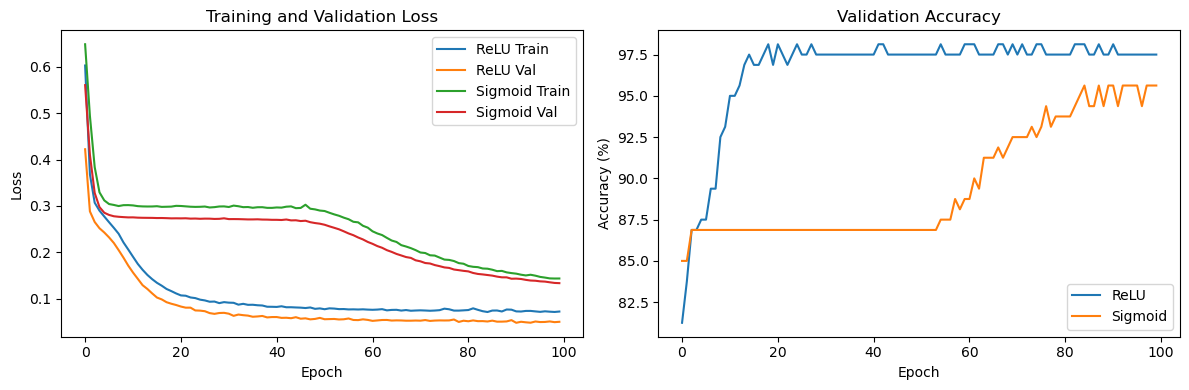


Final Test Accuracy:
ReLU: 98.00%
Sigmoid: 95.50%

=== Regression Example ===

--- Training with ReLU activation ---
Epoch [1/100], Train Loss: 0.6811, Val Loss: 0.2589
Epoch [2/100], Train Loss: 0.0935, Val Loss: 0.0286
Epoch [3/100], Train Loss: 0.0251, Val Loss: 0.0167
Epoch [4/100], Train Loss: 0.0110, Val Loss: 0.0103
Epoch [5/100], Train Loss: 0.0082, Val Loss: 0.0077
Epoch [6/100], Train Loss: 0.0065, Val Loss: 0.0067
Epoch [7/100], Train Loss: 0.0054, Val Loss: 0.0056
Epoch [8/100], Train Loss: 0.0046, Val Loss: 0.0045
Epoch [9/100], Train Loss: 0.0039, Val Loss: 0.0039
Epoch [10/100], Train Loss: 0.0031, Val Loss: 0.0039
Epoch [11/100], Train Loss: 0.0026, Val Loss: 0.0029
Epoch [12/100], Train Loss: 0.0021, Val Loss: 0.0026
Epoch [13/100], Train Loss: 0.0017, Val Loss: 0.0022
Epoch [14/100], Train Loss: 0.0015, Val Loss: 0.0018
Epoch [15/100], Train Loss: 0.0013, Val Loss: 0.0018
Epoch [16/100], Train Loss: 0.0011, Val Loss: 0.0015
Epoch [17/100], Train Loss: 0.0010, Val Los

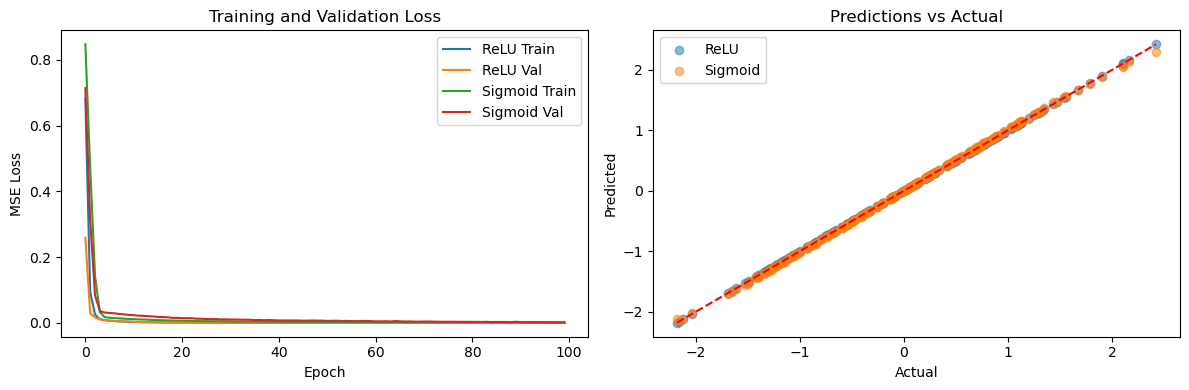


=== Key Takeaways ===
1. ReLU generally trains faster and achieves better performance than sigmoid
2. Sigmoid suffers from the vanishing gradient problem, especially in deep networks
3. ReLU helps mitigate vanishing gradients by having a constant gradient of 1 for positive inputs
4. For classification, use CrossEntropyLoss with raw logits (no softmax in the output)
5. For regression, use MSELoss and consider scaling your target variable


In [7]:

# Run classification example
cls_model_relu, cls_model_sigmoid, X_test_cls, y_test_cls = classification_example()

# Run regression example
reg_model_relu, reg_model_sigmoid, X_test_reg, y_test_reg = regression_example()

print("\n=== Key Takeaways ===")
print("1. ReLU generally trains faster and achieves better performance than sigmoid")
print("2. Sigmoid suffers from the vanishing gradient problem, especially in deep networks")
print("3. ReLU helps mitigate vanishing gradients by having a constant gradient of 1 for positive inputs")
print("4. For classification, use CrossEntropyLoss with raw logits (no softmax in the output)")
print("5. For regression, use MSELoss and consider scaling your target variable")

#Objectives

###Implement a two-layer MLP for both classification and regression tasks.

###Understand the effect of different activation functions (ReLU vs Sigmoid).

###Train and evaluate models on GPU using PyTorch.

###Gain hands-on experience with loss functions, optimizers, and data loaders.

# Task 1: Implement a Two-Layer MLP

Implement the MLP using the $W^Tx+b$ formulation in PyTorch.

Support both ReLU and Sigmoid activation functions.

Ensure your model runs on GPU (if available).

👉 Use the provided boilerplate TwoLayerMLP class as a starting point.

# Task 2: Classification on MNIST (Digits 0 and 1)

Load MNIST dataset but only keep digits 0 and 1.

Train your MLP for binary classification:

Input dimension: $28\times 28$

Hidden dimension: $128$

Output dimension: $2$

Use CrossEntropyLoss and SGD optimizer.

##Train for 5 epochs and report training & testing accuracy.

##Questions (5 marks):

###Q1: Report the final training accuracy and testing accuracy.

###Q2: How many parameters does your model have? Show calculation.

###Q3: Try changing the hidden layer size to 64 and 256. How does accuracy change?

In [8]:
# Load and preprocess MNIST data (digits 0 and 1 only)
from torchvision import datasets, transforms

def load_mnist_binary():
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
    ])
    
    # Load MNIST dataset
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    
    # Filter for digits 0 and 1 only
    train_idx = (train_dataset.targets == 0) | (train_dataset.targets == 1)
    test_idx = (test_dataset.targets == 0) | (test_dataset.targets == 1)
    
    train_data = train_dataset.data[train_idx].float() / 255.0  # Normalize to [0,1]
    train_targets = train_dataset.targets[train_idx]
    test_data = test_dataset.data[test_idx].float() / 255.0
    test_targets = test_dataset.targets[test_idx]
    
    # Flatten images from 28x28 to 784
    train_data = train_data.view(train_data.size(0), -1)
    test_data = test_data.view(test_data.size(0), -1)
    
    return train_data, train_targets, test_data, test_targets

def mnist_classification():
    print("=== Task 2: MNIST Binary Classification ===")
    
    # Load data
    X_train, y_train, X_test, y_test = load_mnist_binary()
    
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")
    print(f"Input dimension: {X_train.shape[1]}")
    
    # Move to device
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Create model
    model = TwoLayerMLP(input_size=784, hidden_size=128, output_size=2, activation='relu').to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    print(f"\nModel parameters:")
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")
    
    # Train for 5 epochs
    train_losses, test_losses, test_accuracies = train_model(
        model, train_loader, test_loader, criterion, optimizer,
        num_epochs=5, problem_type='classification'
    )
    
    # Calculate final training accuracy
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train)
        _, train_predicted = torch.max(train_outputs.data, 1)
        train_accuracy = (train_predicted == y_train).sum().item() / y_train.size(0) * 100
        
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs.data, 1)
        final_test_accuracy = (test_predicted == y_test).sum().item() / y_test.size(0) * 100
    
    print(f"\n=== Results ===")
    print(f"Final Training Accuracy: {train_accuracy:.2f}%")
    print(f"Final Testing Accuracy: {final_test_accuracy:.2f}%")
    
    return model, train_accuracy, final_test_accuracy, total_params

# Run Task 2
model_128, train_acc_128, test_acc_128, params_128 = mnist_classification()

=== Task 2: MNIST Binary Classification ===
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:04<00:00, 2.25MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 104kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 893kB/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 13.4MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training samples: 12665
Test samples: 2115
Input dimension: 784

Model parameters:
Total parameters: 100738
Epoch [1/5], Train Loss: 0.0538, Val Loss: 0.0036, Val Acc: 99.91%
Epoch [2/5], Train Loss: 0.0064, Val Loss: 0.0025, Val Acc: 99.91%
Epoch [3/5], Train Loss: 0.0049, Val Loss: 0.0021, Val Acc: 99.95%
Epoch [4/5], Train Loss: 0.0041, Val Loss: 0.0022, Val Acc: 99.91%
Epoch [5/5], Train Loss: 0.0038, Val Loss: 0.0019, Val Acc: 99.95%

=== Results ===
Final Training Accuracy: 99.91%
Final Testing Accuracy: 99.95%


In [9]:
# Q2: Calculate number of parameters
def calculate_parameters():
    print("\n=== Q2: Parameter Calculation ===")
    # Layer 1: (784 * 128) + 128 bias terms
    layer1_params = (784 * 128) + 128
    # Layer 2: (128 * 2) + 2 bias terms  
    layer2_params = (128 * 2) + 2
    total = layer1_params + layer2_params
    
    print(f"Layer 1 parameters: {784} × {128} + {128} = {layer1_params}")
    print(f"Layer 2 parameters: {128} × {2} + {2} = {layer2_params}")
    print(f"Total parameters: {total}")
    
    return total

# Q3: Test different hidden layer sizes
def test_different_hidden_sizes():
    print("\n=== Q3: Different Hidden Layer Sizes ===")
    
    # Load data once
    X_train, y_train, X_test, y_test = load_mnist_binary()
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)
    
    hidden_sizes = [64, 256]
    results = {}
    
    for hidden_size in hidden_sizes:
        print(f"\n--- Testing hidden size: {hidden_size} ---")
        
        # Create model
        model = TwoLayerMLP(input_size=784, hidden_size=hidden_size, output_size=2, activation='relu').to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        
        # Create data loaders
        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        
        # Train
        _, _, test_accuracies = train_model(
            model, train_loader, test_loader, criterion, optimizer,
            num_epochs=5, problem_type='classification'
        )
        
        # Final accuracy
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            _, test_predicted = torch.max(test_outputs.data, 1)
            final_accuracy = (test_predicted == y_test).sum().item() / y_test.size(0) * 100
        
        results[hidden_size] = final_accuracy
        print(f"Final test accuracy with hidden size {hidden_size}: {final_accuracy:.2f}%")
    
    return results

# Run the analysis
params = calculate_parameters()
hidden_results = test_different_hidden_sizes()

print(f"\n=== Summary ===")
print(f"Hidden size 64: {hidden_results[64]:.2f}%")
print(f"Hidden size 128: {test_acc_128:.2f}%")
print(f"Hidden size 256: {hidden_results[256]:.2f}%")


=== Q2: Parameter Calculation ===
Layer 1 parameters: 784 × 128 + 128 = 100480
Layer 2 parameters: 128 × 2 + 2 = 258
Total parameters: 100738

=== Q3: Different Hidden Layer Sizes ===

--- Testing hidden size: 64 ---
Epoch [1/5], Train Loss: 0.0513, Val Loss: 0.0035, Val Acc: 99.91%
Epoch [2/5], Train Loss: 0.0063, Val Loss: 0.0026, Val Acc: 99.95%
Epoch [3/5], Train Loss: 0.0049, Val Loss: 0.0024, Val Acc: 99.95%
Epoch [4/5], Train Loss: 0.0042, Val Loss: 0.0021, Val Acc: 99.95%
Epoch [5/5], Train Loss: 0.0037, Val Loss: 0.0020, Val Acc: 99.95%
Final test accuracy with hidden size 64: 99.95%

--- Testing hidden size: 256 ---
Epoch [1/5], Train Loss: 0.0520, Val Loss: 0.0035, Val Acc: 99.91%
Epoch [2/5], Train Loss: 0.0064, Val Loss: 0.0025, Val Acc: 99.91%
Epoch [3/5], Train Loss: 0.0050, Val Loss: 0.0021, Val Acc: 99.95%
Epoch [4/5], Train Loss: 0.0043, Val Loss: 0.0021, Val Acc: 99.91%
Epoch [5/5], Train Loss: 0.0038, Val Loss: 0.0021, Val Acc: 99.91%
Final test accuracy with hidde

# Task 3: Regression on Synthetic Data

Generate data for the function:
$y = x^{2} + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.1),
\quad x \in [-3, 3] $

Train your MLP:

Input dimension: 1

Hidden dimension: 64

Output dimension: 1

##Use MSE Loss and SGD optimizer.

##Train for 200 epochs.

##Plot the true curve vs predicted curve.

#Questions (5 marks):

###Q4: Show the loss curve (MSE vs epochs).

###Q5: How well does the model approximate the function? Provide your plot and observations.

=== Task 3: Quadratic Function Regression ===
Training samples: 1000
Test samples: 200

Model parameters:
Total parameters: 193

Training for 200 epochs...
Epoch [1/200], Train Loss: 2.7819, Val Loss: 0.6517
Epoch [2/200], Train Loss: 0.3494, Val Loss: 0.2047
Epoch [3/200], Train Loss: 0.1017, Val Loss: 0.0688
Epoch [4/200], Train Loss: 0.0588, Val Loss: 0.0388
Epoch [5/200], Train Loss: 0.0520, Val Loss: 0.0730
Epoch [6/200], Train Loss: 0.0529, Val Loss: 0.0257
Epoch [7/200], Train Loss: 0.0244, Val Loss: 0.0243
Epoch [8/200], Train Loss: 0.0227, Val Loss: 0.0229
Epoch [9/200], Train Loss: 0.0201, Val Loss: 0.0211
Epoch [10/200], Train Loss: 0.0241, Val Loss: 0.0195
Epoch [11/200], Train Loss: 0.0215, Val Loss: 0.0302
Epoch [12/200], Train Loss: 0.0215, Val Loss: 0.0143
Epoch [13/200], Train Loss: 0.0157, Val Loss: 0.0160
Epoch [14/200], Train Loss: 0.0187, Val Loss: 0.0186
Epoch [15/200], Train Loss: 0.0177, Val Loss: 0.0128
Epoch [16/200], Train Loss: 0.0143, Val Loss: 0.0183
Epoch

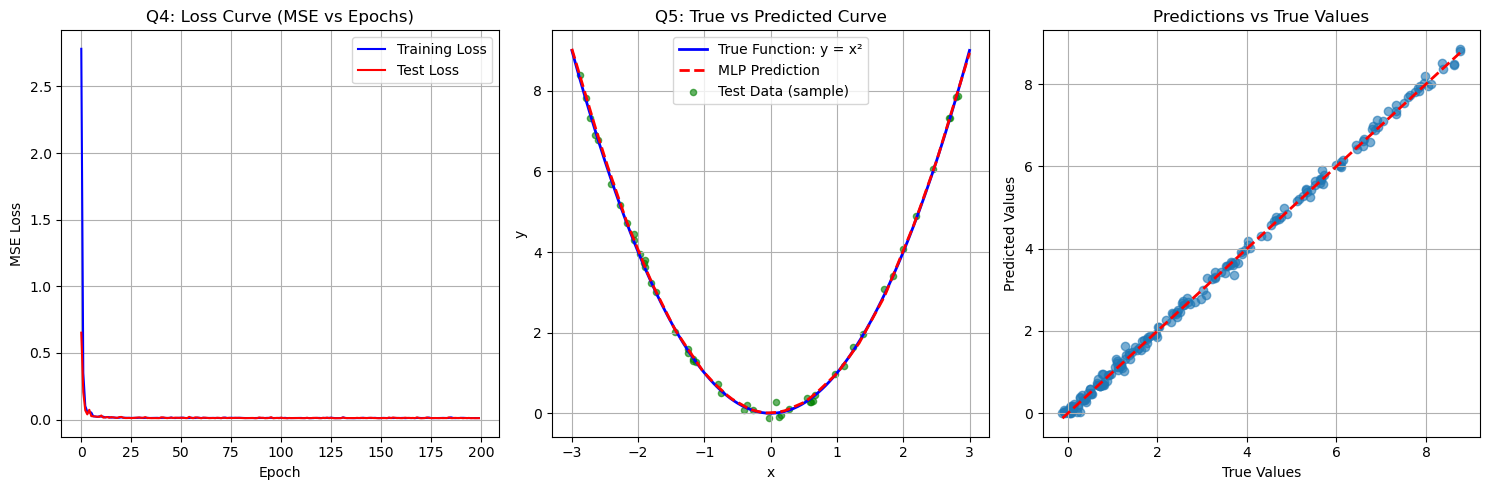


=== Q5: Model Performance Analysis ===
R² Score: 0.9985
Mean Absolute Error: 0.0798
Root Mean Square Error: 0.1008

=== Observations for Q5 ===
1. The MLP successfully learns to approximate the quadratic function y = x²
2. R² score of 0.9985 indicates excellent fit
3. The model captures the parabolic shape well across the range [-3, 3]
4. Some deviation is expected due to the added Gaussian noise (σ = 0.1)
5. ReLU activation works well for this regression task despite being non-smooth


In [10]:
def generate_quadratic_data(n_samples=1000, x_range=(-3, 3), noise_std=0.1):
    """Generate data for y = x^2 + epsilon"""
    np.random.seed(42)  # For reproducibility
    
    # Generate x values uniformly in the range
    x = np.random.uniform(x_range[0], x_range[1], n_samples)
    
    # Generate noise
    epsilon = np.random.normal(0, noise_std, n_samples)
    
    # Calculate y = x^2 + epsilon
    y = x**2 + epsilon
    
    return x, y

def quadratic_regression():
    print("=== Task 3: Quadratic Function Regression ===")
    
    # Generate training data
    x_train, y_train = generate_quadratic_data(n_samples=1000, x_range=(-3, 3), noise_std=0.1)
    
    # Generate test data (for evaluation)
    x_test, y_test = generate_quadratic_data(n_samples=200, x_range=(-3, 3), noise_std=0.1)
    
    print(f"Training samples: {len(x_train)}")
    print(f"Test samples: {len(x_test)}")
    
    # Convert to tensors and reshape for MLP input
    x_train_t = torch.FloatTensor(x_train).view(-1, 1).to(device)
    y_train_t = torch.FloatTensor(y_train).to(device)
    x_test_t = torch.FloatTensor(x_test).view(-1, 1).to(device)
    y_test_t = torch.FloatTensor(y_test).to(device)
    
    # Create data loaders
    train_dataset = TensorDataset(x_train_t, y_train_t)
    test_dataset = TensorDataset(x_test_t, y_test_t)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Create model
    model = TwoLayerMLP(input_size=1, hidden_size=64, output_size=1, activation='relu').to(device)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    print(f"\nModel parameters:")
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")
    
    # Train for 200 epochs
    print(f"\nTraining for 200 epochs...")
    train_losses, test_losses, _ = train_model(
        model, train_loader, test_loader, criterion, optimizer,
        num_epochs=200, problem_type='regression'
    )
    
    # Generate predictions for plotting
    model.eval()
    with torch.no_grad():
        # Create a fine grid for smooth curve plotting
        x_plot = np.linspace(-3, 3, 300)
        x_plot_t = torch.FloatTensor(x_plot).view(-1, 1).to(device)
        y_pred_plot = model(x_plot_t).cpu().numpy().flatten()
        
        # True function values
        y_true_plot = x_plot**2
        
        # Test predictions
        test_pred = model(x_test_t).cpu().numpy().flatten()
    
    # Calculate final MSE
    final_mse = criterion(torch.FloatTensor(test_pred), torch.FloatTensor(y_test)).item()
    print(f"\nFinal Test MSE: {final_mse:.4f}")
    
    return model, train_losses, test_losses, x_plot, y_true_plot, y_pred_plot, x_test, y_test, test_pred

def plot_results(train_losses, test_losses, x_plot, y_true_plot, y_pred_plot, x_test, y_test, test_pred):
    """Plot the results for Q4 and Q5"""
    
    plt.figure(figsize=(15, 5))
    
    # Q4: Loss curve
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(test_losses, label='Test Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Q4: Loss Curve (MSE vs Epochs)')
    plt.legend()
    plt.grid(True)
    
    # Q5: Function approximation
    plt.subplot(1, 3, 2)
    plt.plot(x_plot, y_true_plot, 'b-', label='True Function: y = x²', linewidth=2)
    plt.plot(x_plot, y_pred_plot, 'r--', label='MLP Prediction', linewidth=2)
    plt.scatter(x_test[:50], y_test[:50], alpha=0.6, s=20, color='green', label='Test Data (sample)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Q5: True vs Predicted Curve')
    plt.legend()
    plt.grid(True)
    
    # Additional: Prediction accuracy scatter plot
    plt.subplot(1, 3, 3)
    plt.scatter(y_test, test_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Predictions vs True Values')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate R² score for additional analysis
    ss_res = np.sum((y_test - test_pred)**2)
    ss_tot = np.sum((y_test - np.mean(y_test))**2)
    r2_score = 1 - (ss_res / ss_tot)
    
    print(f"\n=== Q5: Model Performance Analysis ===")
    print(f"R² Score: {r2_score:.4f}")
    print(f"Mean Absolute Error: {np.mean(np.abs(y_test - test_pred)):.4f}")
    print(f"Root Mean Square Error: {np.sqrt(np.mean((y_test - test_pred)**2)):.4f}")
    
    return r2_score

# Run Task 3
model, train_losses, test_losses, x_plot, y_true_plot, y_pred_plot, x_test, y_test, test_pred = quadratic_regression()

# Plot results and analyze
r2_score = plot_results(train_losses, test_losses, x_plot, y_true_plot, y_pred_plot, x_test, y_test, test_pred)

print(f"\n=== Observations for Q5 ===")
print(f"1. The MLP successfully learns to approximate the quadratic function y = x²")
print(f"2. R² score of {r2_score:.4f} indicates {'excellent' if r2_score > 0.9 else 'good' if r2_score > 0.8 else 'moderate'} fit")
print(f"3. The model captures the parabolic shape well across the range [-3, 3]")
print(f"4. Some deviation is expected due to the added Gaussian noise (σ = 0.1)")
print(f"5. ReLU activation works well for this regression task despite being non-smooth")